# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [4]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

KeyboardInterrupt: 

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [10]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [11]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([-0.48033676, -0.49907076, -0.12563428,  0.36635143,  0.99469095,
       -1.1216103 ,  0.7808449 ,  0.06897827, -0.57774   , -2.07946   ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [7]:
senReleasesW2V.wv.syn0

array([[-1.29856586e+00,  3.12571883e-01, -6.46152675e-01, ...,
         9.90776777e-01,  3.24493676e-01, -3.64532650e-01],
       [-5.22194020e-02,  8.59209478e-01,  3.19032729e-01, ...,
         3.52013648e-01, -1.16896284e+00,  2.74213433e-01],
       [-1.01878238e+00, -1.12904084e+00,  1.41845834e+00, ...,
         1.35756409e+00, -1.91561925e+00, -5.78513026e-01],
       ...,
       [ 4.52833958e-02,  2.88827904e-02,  1.05804885e-02, ...,
         3.02729080e-03, -1.60823800e-02,  1.90404593e-03],
       [ 7.31514394e-02,  7.75759444e-02, -3.27942707e-02, ...,
         1.56790502e-02, -5.40540777e-02,  1.08741418e-01],
       [ 1.27396733e-02,  3.58242914e-02, -1.09655457e-02, ...,
         4.18828800e-02, -6.01133378e-03,  1.43555487e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [8]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [9]:
senReleasesW2V.most_similar('president')

[('administration', 0.8283464312553406),
 ('presidents', 0.7914415597915649),
 ('administrations', 0.7751102447509766),
 ('linean', 0.6842581629753113),
 ('cheney', 0.6636990308761597),
 ('rollback', 0.6445888876914978),
 ('responds', 0.6028443574905396),
 ('veto', 0.596078634262085),
 ('reserving', 0.5842287540435791),
 ('w.', 0.5778374671936035)]

In [10]:
senReleasesW2V.most_similar('war')

[('invade', 0.6993921995162964),
 ('wars', 0.6972939968109131),
 ('unresisted', 0.693369448184967),
 ('afghanistan', 0.6870641112327576),
 ('liberation', 0.6825169324874878),
 ('foment', 0.6709116101264954),
 ('disobedience', 0.6639421582221985),
 ('unwinnable', 0.6385154724121094),
 ('eviction', 0.6379228830337524),
 ('chaos', 0.6280709505081177)]

Find which word least matches the others within a word set (cosine similarity):

In [11]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [12]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('reagan', 0.7111105918884277),
 ('nixon', 0.6991130113601685),
 ('signature', 0.67856764793396),
 ('roosevelt', 0.6618903875350952),
 ('bushs', 0.6556457281112671),
 ('bush', 0.6553600430488586),
 ('dwight', 0.6487621665000916),
 ('veto', 0.6264448165893555),
 ('ford', 0.6215455532073975),
 ('lyndon', 0.6209505796432495)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [13]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [14]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [15]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.2985659 ,  0.31257188, -0.6461527 , ...,  0.9907768 ,
         0.32449368, -0.36453265],
       [-0.0522194 ,  0.8592095 ,  0.31903273, ...,  0.35201365,
        -1.1689628 ,  0.27421343],
       [-1.0187824 , -1.1290408 ,  1.4184583 , ...,  1.3575641 ,
        -1.9156193 , -0.578513  ],
       ...,
       [ 0.7261309 ,  1.0728214 , -0.25613877, ..., -1.4942498 ,
         1.37964   , -1.0396935 ],
       [-0.45212147,  1.9865396 , -0.5438519 , ...,  0.1781534 ,
         0.72487944, -0.35405028],
       [ 2.120718  ,  1.1636872 , -2.078742  , ...,  1.6376282 ,
         1.7728649 ,  2.885328  ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [16]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

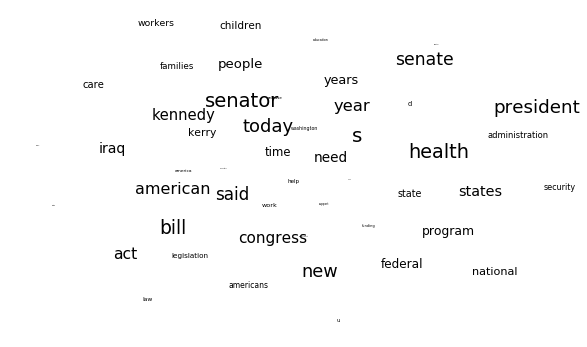

In [17]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [19]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [20]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [21]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [22]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [23]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [24]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [209]:
speeches = pandas.read_csv("presidential_speeches.csv")
speeches = speeches.rename(columns={'Unnamed: 0': 'title', 'President': 'president', 'Date': 'date', 'Speech': 'text'})
speeches['subtype'] = 'Speech'
print(speeches.shape)
speeches.head(2)

(335, 5)


,title,president,date,text,subtype
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech


In [210]:
orders = pandas.read_csv("exec_orders_w_text")
orders = orders.rename(columns={'publication_date': 'date', 'order_text': 'text'})
print(orders.shape)
orders.head(2)

(1042, 16)


,Unnamed: 0,citation,document_number,end_page,html_url,pdf_url,type,subtype,date,signing_date,start_page,title,disposition_notes,executive_order_number,president,text
0,0,82 FR 8115,2017-01623,8129,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/23/2017,01/17/2017,8115,"Amending the Civil Service Rules, Executive Or...","Amends: EO 13467, June 30, 2008; EO 13488, Jan...",13764.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
1,1,82 FR 7619,2017-01487,7620,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/19/2017,01/13/2017,7619,Providing an Order of Succession Within the De...,"Revokes: EO 13557, November 4, 2010\nRevoked b...",13762.0,barack_obama,"\n\n\nExecutive Order 13762 of January 13, 201..."


In [211]:
data = speeches.append(orders[['title', 'president', 'date', 'text', 'subtype']])
data = data[data['text'].notna()]
print(data.shape)
data.head(2)

(1152, 5)


,title,president,date,text,subtype
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech


In [212]:
data['tokenized_sents'] = data['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

data[:100:10]

,title,president,date,text,subtype,tokenized_sents,normalized_sents
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech,"[[Chief, Justice, Roberts, Vice, President, Ha...","[[chief, justice, roberts, vice, president, ha..."
12,june-1-2020-statement-protests-against-police-...,Donald Trump,"June 01, 2020",\n \n\n\n\n\n\nThank you very much. My fe...,Speech,"[[Thank, you, very, much], [My, fellow, Americ...","[[thank], [fellow, americans], [high, duty, pr..."
31,march-19-2018-remarks-combating-opioid-crisis,Donald Trump,"March 19, 2018",\n \n\n\n\n\n\nTHE PRESIDENT: Thank you t...,Speech,"[[THE, PRESIDENT], [Thank, you, to, our, First...","[[president], [thank, lady, melania, incredibl..."
42,january-20-2017-inaugural-address,Donald Trump,"January 20, 2017","\n \n\n\n\n\n\nChief Justice Roberts, Pre...",Speech,"[[Chief, Justice, Roberts, President, Carter, ...","[[chief, justice, roberts, president, carter, ..."
55,april-8-2013-speech-gun-violence,Barack Obama,"April 08, 2013","\n \n\n\n\n\n\nHello, Connecticut. (Appl...",Speech,"[[Hello, Connecticut], [Applause], [Thank, you...","[[hello, connecticut], [applause], [thank], [t..."
67,june-22-2011-remarks-afghanistan-pullout,Barack Obama,"June 22, 2011",\n \n\n\n\n\n\nGood evening. Nearly 10 y...,Speech,"[[Good, evening], [Nearly, 10, years, ago, Ame...","[[good, even], [nearly, year, ago, america, su..."
80,february-9-2010-news-conference-congressional-...,Barack Obama,"February 09, 2010","\n \n\n\n\n\n\nTHE PRESIDENT: Hello, eve...",Speech,"[[THE, PRESIDENT], [Hello, everybody], [I, am,...","[[president], [hello, everybody], [glad, brave..."
90,january-20-2009-inaugural-address,Barack Obama,"January 20, 2009",\n \n\n\n\n\n\nI stand here today humbled...,Speech,"[[I, stand, here, today, humbled, by, the, tas...","[[stand, today, humble, task, grateful, trust,..."
100,april-9-2007-speech-comprehensive-immigration-...,George W. Bush,"April 09, 2007",\n \n\n\n\n\n\nTHE PRESIDENT: Thank you a...,Speech,"[[THE, PRESIDENT], [Thank, you, all], [Thank, ...","[[president], [thank], [thank, seat], [thank, ..."
110,september-3-2004-remarks-republican-national-c...,George W. Bush,"September 03, 2004",\n \n\n\n\n\n\nTHE PRESIDENT: Thank you a...,Speech,"[[THE, PRESIDENT], [Thank, you, all], [Applaus...","[[president], [thank], [applause], [mr, chairm..."


In [213]:
def plot_2D(W2Vmodel, numWords=50, n_components=2, plotType='tsne', size=True):
    targetWords = W2Vmodel.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(W2Vmodel[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    wordsSubMatrix

    if plotType == 'tsne':
        #pcaWords = sklearn.decomposition.PCA(n_components = n_components).fit(wordsSubMatrix)
        #reducedPCA_data = pcaWords.transform(wordsSubMatrix)
        plotWords = sklearn.manifold.TSNE(n_components = n_components).fit_transform(wordsSubMatrix)
    
    if plotType == 'pca':
        pcaWords = sklearn.decomposition.PCA(n_components = n_components).fit(wordsSubMatrix)
        plotWords = pcaWords.transform(wordsSubMatrix)
        #plotWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)   
        
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(plotWords[:, 0], plotWords[:, 1], alpha = 0)#Making the points invisible 
    if size:
        for i, word in enumerate(targetWords):
            ax.annotate(word, (plotWords[:, 0][i], plotWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    else:
        for i, word in enumerate(targetWords):
            ax.annotate(word, (plotWords[:, 0][i], plotWords[:, 1][i]))        
    plt.xticks(())
    plt.yticks(())
    plt.show()

speech Word2Vec(vocab=5667, size=100, alpha=0.025) pca


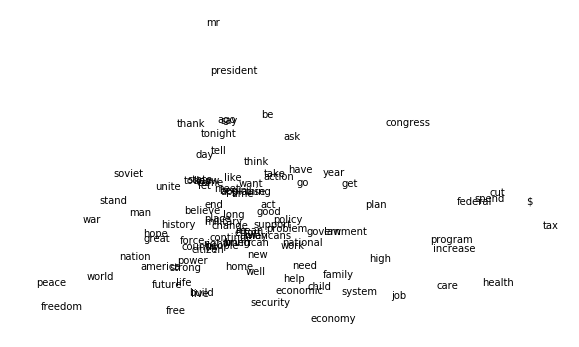

speech Word2Vec(vocab=5667, size=100, alpha=0.025) tsne


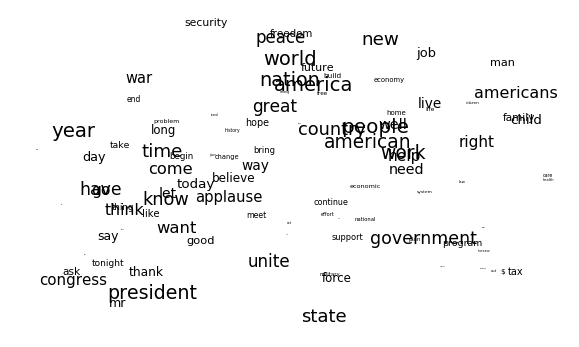

orders Word2Vec(vocab=4273, size=100, alpha=0.025) pca


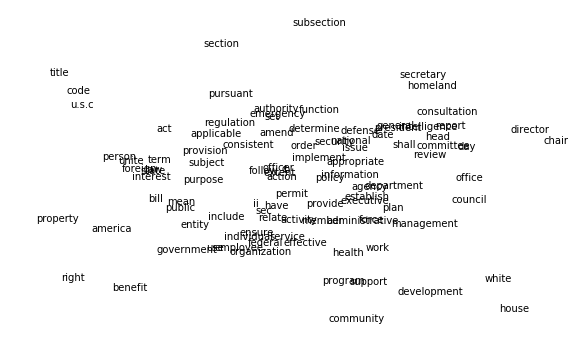

orders Word2Vec(vocab=4273, size=100, alpha=0.025) tsne


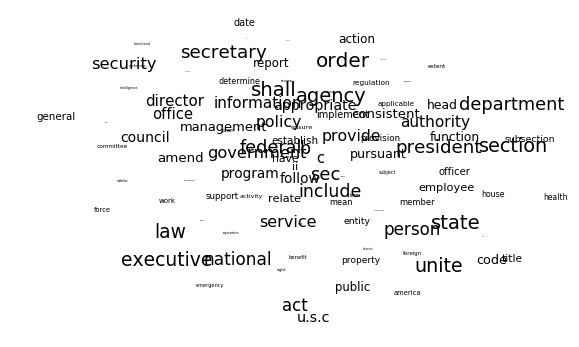

both Word2Vec(vocab=7599, size=100, alpha=0.025) pca


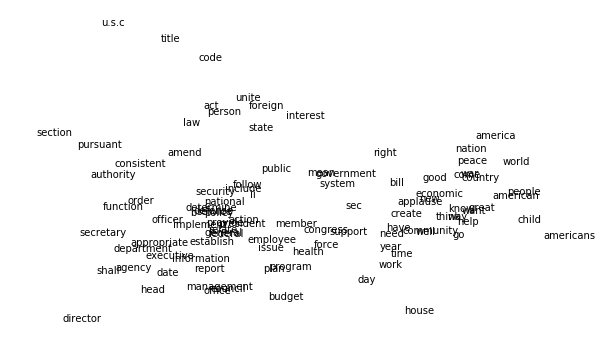

both Word2Vec(vocab=7599, size=100, alpha=0.025) tsne


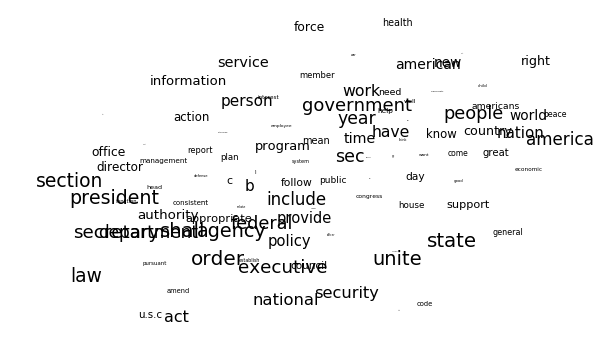

In [92]:
speechesW2V = gensim.models.word2vec.Word2Vec(data[data['subtype'] =='Speech']['normalized_sents'].sum())
ordersW2V = gensim.models.word2vec.Word2Vec(data[data['subtype'] =='Executive Order']['normalized_sents'].sum())
dataW2V = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

for model in ((speechesW2V, 'speech'), (ordersW2V, 'orders'), (dataW2V, 'both')):
    print(model[1], model[0], 'pca')
    plot_2D(model[0], numWords=100, n_components=2, plotType='pca', size=False)
    print(model[1], model[0], 'tsne')
    plot_2D(model[0], numWords=100, n_components=2, plotType='tsne', size=True)

From above, the words distribution differ between the speeches corpus vs. the executive orders corpus vs. both of them combined.

It's not super clear what the x and y dimensions are representing in these figures. But, if I have to guess, it looks like:

1. For the speeches corpus, according to PCA, the 2 most "signficant" dimensions are: 
- left to right: general & societal aspects (e.g, peace, freedom, etc.) -> policy (e.g., program, tax, etc.)
- top to bottom: less clear to me, maybe individual (e.g., president, verbs like take, get, etc.) -> community (e.g., family, community, etc).
And TSNE puts peace and freedom together, people and work together, which makes sense.


2. For the executive orders corpus, the PCA results don't make immediate sense to me. But TSNE puts law and executive together, federal and government together, which makes sense.


3. For the Combined corpus, according to PCA, the 2 most "signficant" dimensions are: 
- left to right: executive orders top words (e.g, section, president, law, etc.) -> speeches top words (e.g., people, world, peace, etc.)
- top to bottom: less clear to me, maybe people/nation/country specific (e.g., foreign, state, person, etc.) -> program specific (e.g., budget, plan, etc).
And TSNE puts national and security together, people, nation, and america together, which also makes sense.

Looking at the Combined corpus with different specifications for the Word2Vec model:

sg =  0


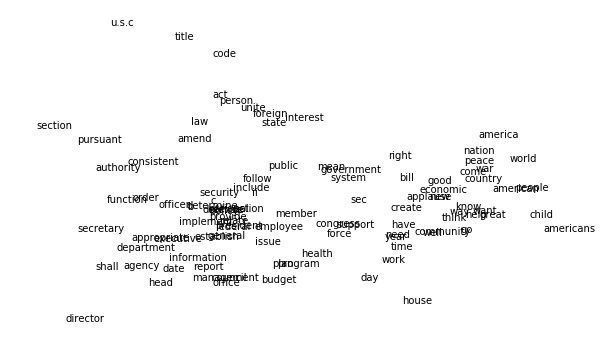

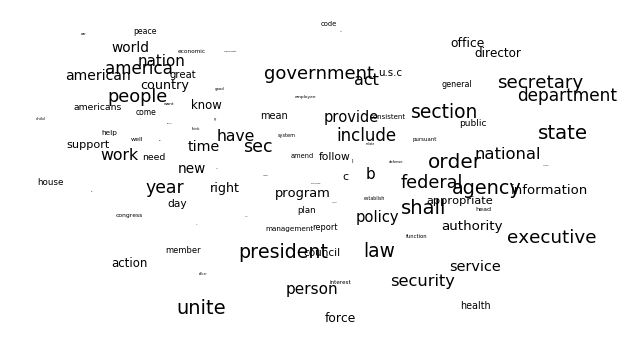

sg =  1


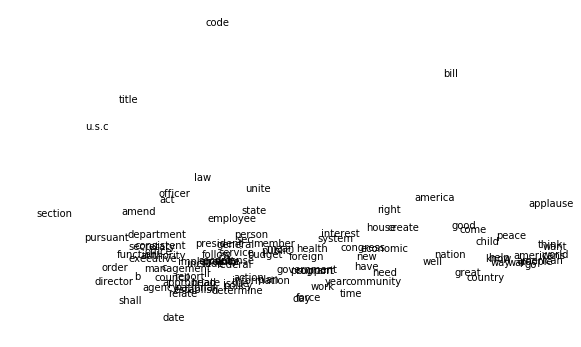

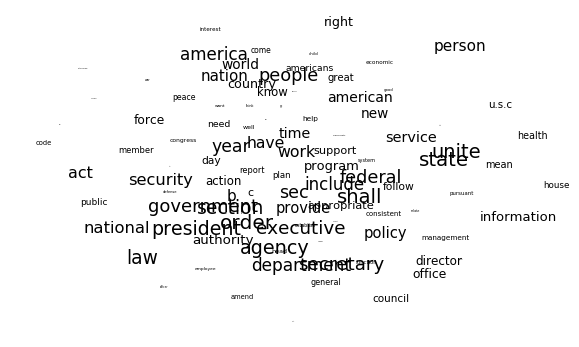

In [97]:
for sg in (0, 1):
    print('sg = ', sg)
    dataW2V = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum(), sg=sg, alpha=0.025, window=5, min_count=5)
    plot_2D(dataW2V, numWords=100, n_components=2, plotType='pca', size=False)
    plot_2D(dataW2V, numWords=100, n_components=2, plotType='tsne', size=True)

The interpretation is not super obvious with just 2 dimensions. But the PCA results above suggests that CBOW is probably a more meaningful model for our purpose.

alpha =  0.25


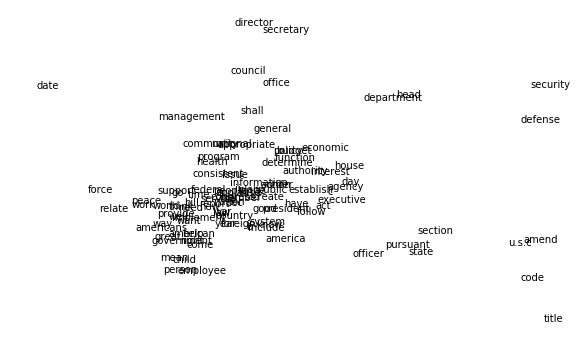

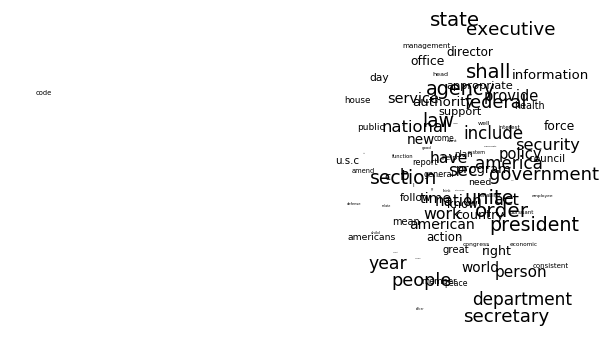

alpha =  0.025


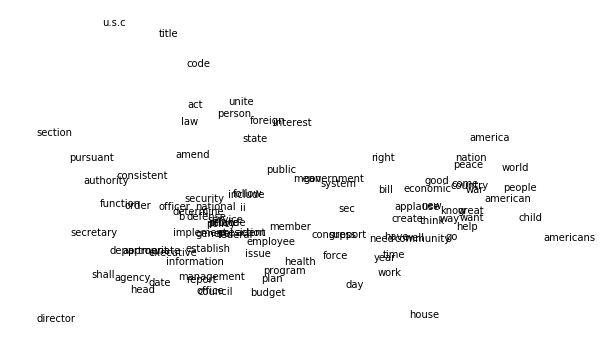

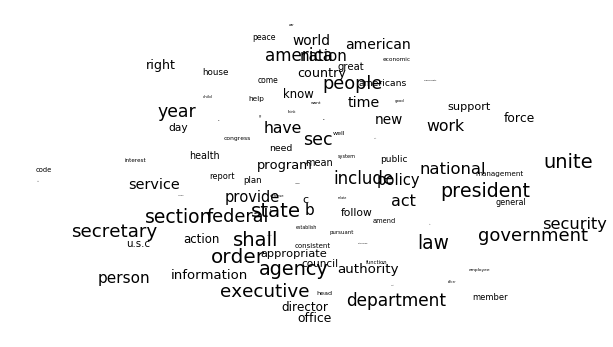

alpha =  0.0025


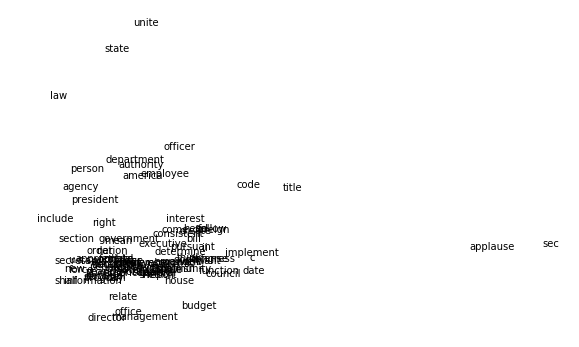

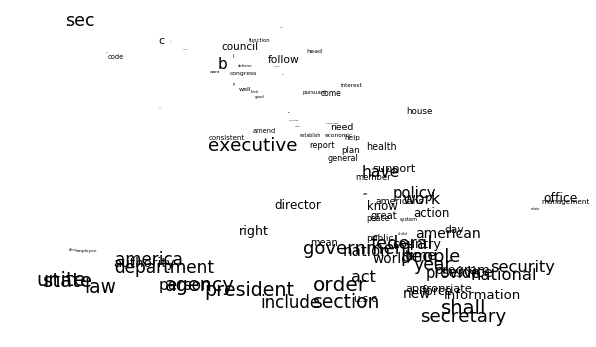

In [100]:
for alpha in (0.25, 0.025, 0.0025):
    print('alpha = ', alpha)
    dataW2V = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum(), sg=0, alpha=alpha, window=5, min_count=5)
    plot_2D(dataW2V, numWords=100, n_components=2, plotType='pca', size=False)
    plot_2D(dataW2V, numWords=100, n_components=2, plotType='tsne', size=True)

The above suggests that tuning alphas generates very different results. Although, it's unclear which one is best though. 

In [218]:
speechesW2V = gensim.models.word2vec.Word2Vec(data[data['subtype'] =='Speech']['normalized_sents'].sum())
ordersW2V = gensim.models.word2vec.Word2Vec(data[data['subtype'] =='Executive Order']['normalized_sents'].sum())
dataW2V = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

Output most similar words to 'climate' from the 3 different corpuses.

In [219]:
for word in ('race', 'climate', 'health'):
    print('Most similar words to ', word)
    print('In Speeches, are: ')
    print(speechesW2V.most_similar(word)[:5])
    print('In Executive Orders, are: ')
    print(ordersW2V.most_similar(word)[:5])
    print('In Both, are')
    print(dataW2V.most_similar(word)[:5])
    print('\\')

Most similar words to  race
In Speeches, are: 
[('terrorize', 0.9511139392852783), ('extremism', 0.9475314617156982), ('extremist', 0.9468775987625122), ('totalitarian', 0.9456726908683777), ('powerful', 0.9432497024536133)]
In Executive Orders, are: 
[('sex', 0.9693353176116943), ('sexual', 0.9188778400421143), ('scapegoat', 0.9042366147041321), ('color', 0.9029882550239563), ('stereotype', 0.8918395042419434)]
In Both, are
[('sex', 0.891430139541626), ('murder', 0.8435454964637756), ('sexual', 0.8257958292961121), ('religion', 0.8144088983535767), ('kill', 0.8004601001739502)]
\
Most similar words to  climate
In Speeches, are: 
[('adapt', 0.9912506341934204), ('successful', 0.989103376865387), ('protectionism', 0.9871484041213989), ('failure', 0.9863409399986267), ('containment', 0.9855011105537415)]
In Executive Orders, are: 
[('resilience', 0.9485920667648315), ('impact', 0.8601897954940796), ('arctic', 0.856032133102417), ('ocean', 0.8344689011573792), ('resilient', 0.827967584133

It looks like, the most similar words to 'race', 'climate' and 'health' are quite different between Speeches and Executive Orders.

In [220]:
for word in ('race', 'climate', 'health'):
    print('In Speeches')
    print(word, 'to Obama is like')
    print(speechesW2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(speechesW2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('In Executive Orders')
    print(word, 'to Obama is like')
    print(ordersW2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(ordersW2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('In Both')
    print(word, 'to Obama is like')
    print(dataW2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(dataW2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('\\')

In Speeches
race to Obama is like
[('pursuit', 0.9492894411087036), ('potential', 0.9489282369613647), ('religious', 0.9473089575767517), ('totalitarian', 0.9456669092178345), ('religion', 0.9425935745239258)]
to Trump
 
And, race to Trump is like
[('terrorize', 0.9523730278015137), ('violence', 0.9504557847976685), ('extremism', 0.9470847845077515), ('extremist', 0.945738673210144), ('capture', 0.9446452260017395)]
to Obama
 
In Executive Orders
race to Obama is like
[('sex', 0.9414635300636292), ('color', 0.8856920003890991), ('sexual', 0.8773634433746338), ('scapegoat', 0.8672972321510315), ('kill', 0.8650988340377808)]
to Trump
 
And, race to Trump is like
[('sex', 0.9546290636062622), ('sexual', 0.9162231087684631), ('scapegoat', 0.8986979722976685), ('inherently', 0.8907386660575867), ('stereotype', 0.8855794668197632)]
to Obama
 
In Both
race to Obama is like
[('sex', 0.8010458946228027), ('religion', 0.7810805439949036), ('murder', 0.7584249377250671), ('innocent', 0.7166936397

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [25]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [26]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [27]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [28]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [29]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [30]:
apsD2V.docvecs[1952]

array([ 0.19856402, -0.32607275, -0.5434297 ,  1.1079134 , -0.7955435 ,
        0.99836284,  0.02586303, -0.77402437,  0.74257386,  1.140868  ,
       -2.4344554 , -0.13921498, -1.2160647 , -1.4391065 , -0.63838714,
        2.1025863 , -0.12144856, -1.331758  ,  0.01048518, -0.6495456 ,
        1.7060442 ,  0.18673746, -0.35625997, -0.8610773 , -0.86390185,
        1.0696704 , -0.23027356,  0.04415682,  0.92669034, -0.50605357,
       -1.2538182 , -0.8345244 ,  1.09148   , -0.9151546 , -1.3085489 ,
       -1.5950308 , -0.54413456,  2.0067692 ,  0.04618606,  1.4554724 ,
        1.4843128 ,  1.5505302 , -1.2077212 , -0.2808706 ,  1.2828134 ,
        0.9156761 , -0.69469404, -0.44501895, -0.50577635,  0.54679835,
       -0.43360424, -0.2895272 , -1.8368219 ,  0.46414116,  0.60980177,
       -0.03472868,  0.7123255 , -0.79734975,  1.5043598 ,  0.6873778 ,
        1.3033248 , -0.2133346 ,  0.22569688, -1.3537297 ,  0.7381637 ,
       -0.10078208, -1.7898892 , -0.2197677 , -0.65157926, -0.50

The words can still be accessed in the same way:

In [31]:
apsD2V['atom']

array([ 0.18284628, -0.04895942, -0.89525455,  0.386619  ,  0.15722378,
        0.28620473,  0.34100235,  0.6834194 , -0.00408947,  0.6566478 ,
       -0.5354382 ,  0.01004452,  0.43740138, -1.091602  ,  0.22807835,
        0.71692365, -0.37653923, -0.10362295, -0.16604191,  0.3131635 ,
       -0.35241136, -0.8172237 ,  0.3936495 , -0.5299927 ,  0.13411738,
        0.2986211 , -0.45632944,  0.00526831,  0.7483204 , -0.34703842,
       -0.8986433 , -0.25062317,  0.16325492, -1.1789956 ,  0.1183672 ,
        0.30810228, -1.107009  ,  0.42208552,  0.41748974,  0.7264739 ,
        0.8722728 ,  1.4183432 , -0.25191745,  0.8265018 ,  0.19808555,
        0.23069115, -0.17685364, -0.29582533,  0.05870611,  0.10616075,
       -0.45562714,  0.17342158, -0.25422886,  0.7015164 ,  0.7497404 ,
       -0.07426755,  1.2640078 , -0.19158858, -0.70047724,  0.10496335,
       -0.91657907, -0.8523482 ,  0.6237608 , -0.09004818,  0.08607046,
       -0.2238795 ,  0.4310083 , -0.21755084, -1.1692094 , -0.53

We can still use the ``most_similar`` command to perform simple semantic equations:

In [32]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.808495819568634)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [33]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('resemblance', 0.9027340412139893)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [34]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.63588536]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [35]:
apsD2V.docvecs.most_similar([apsD2V['electron']], topn=5 )

[('10.1103/PhysRev.113.479', 0.6609346866607666),
 ('10.1103/PhysRev.104.1528', 0.6466891169548035),
 ('10.1103/PhysRev.110.857', 0.6089353561401367),
 ('10.1103/PhysRev.106.191', 0.6088852882385254),
 ('10.1103/PhysRev.100.1646', 0.6056019067764282)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

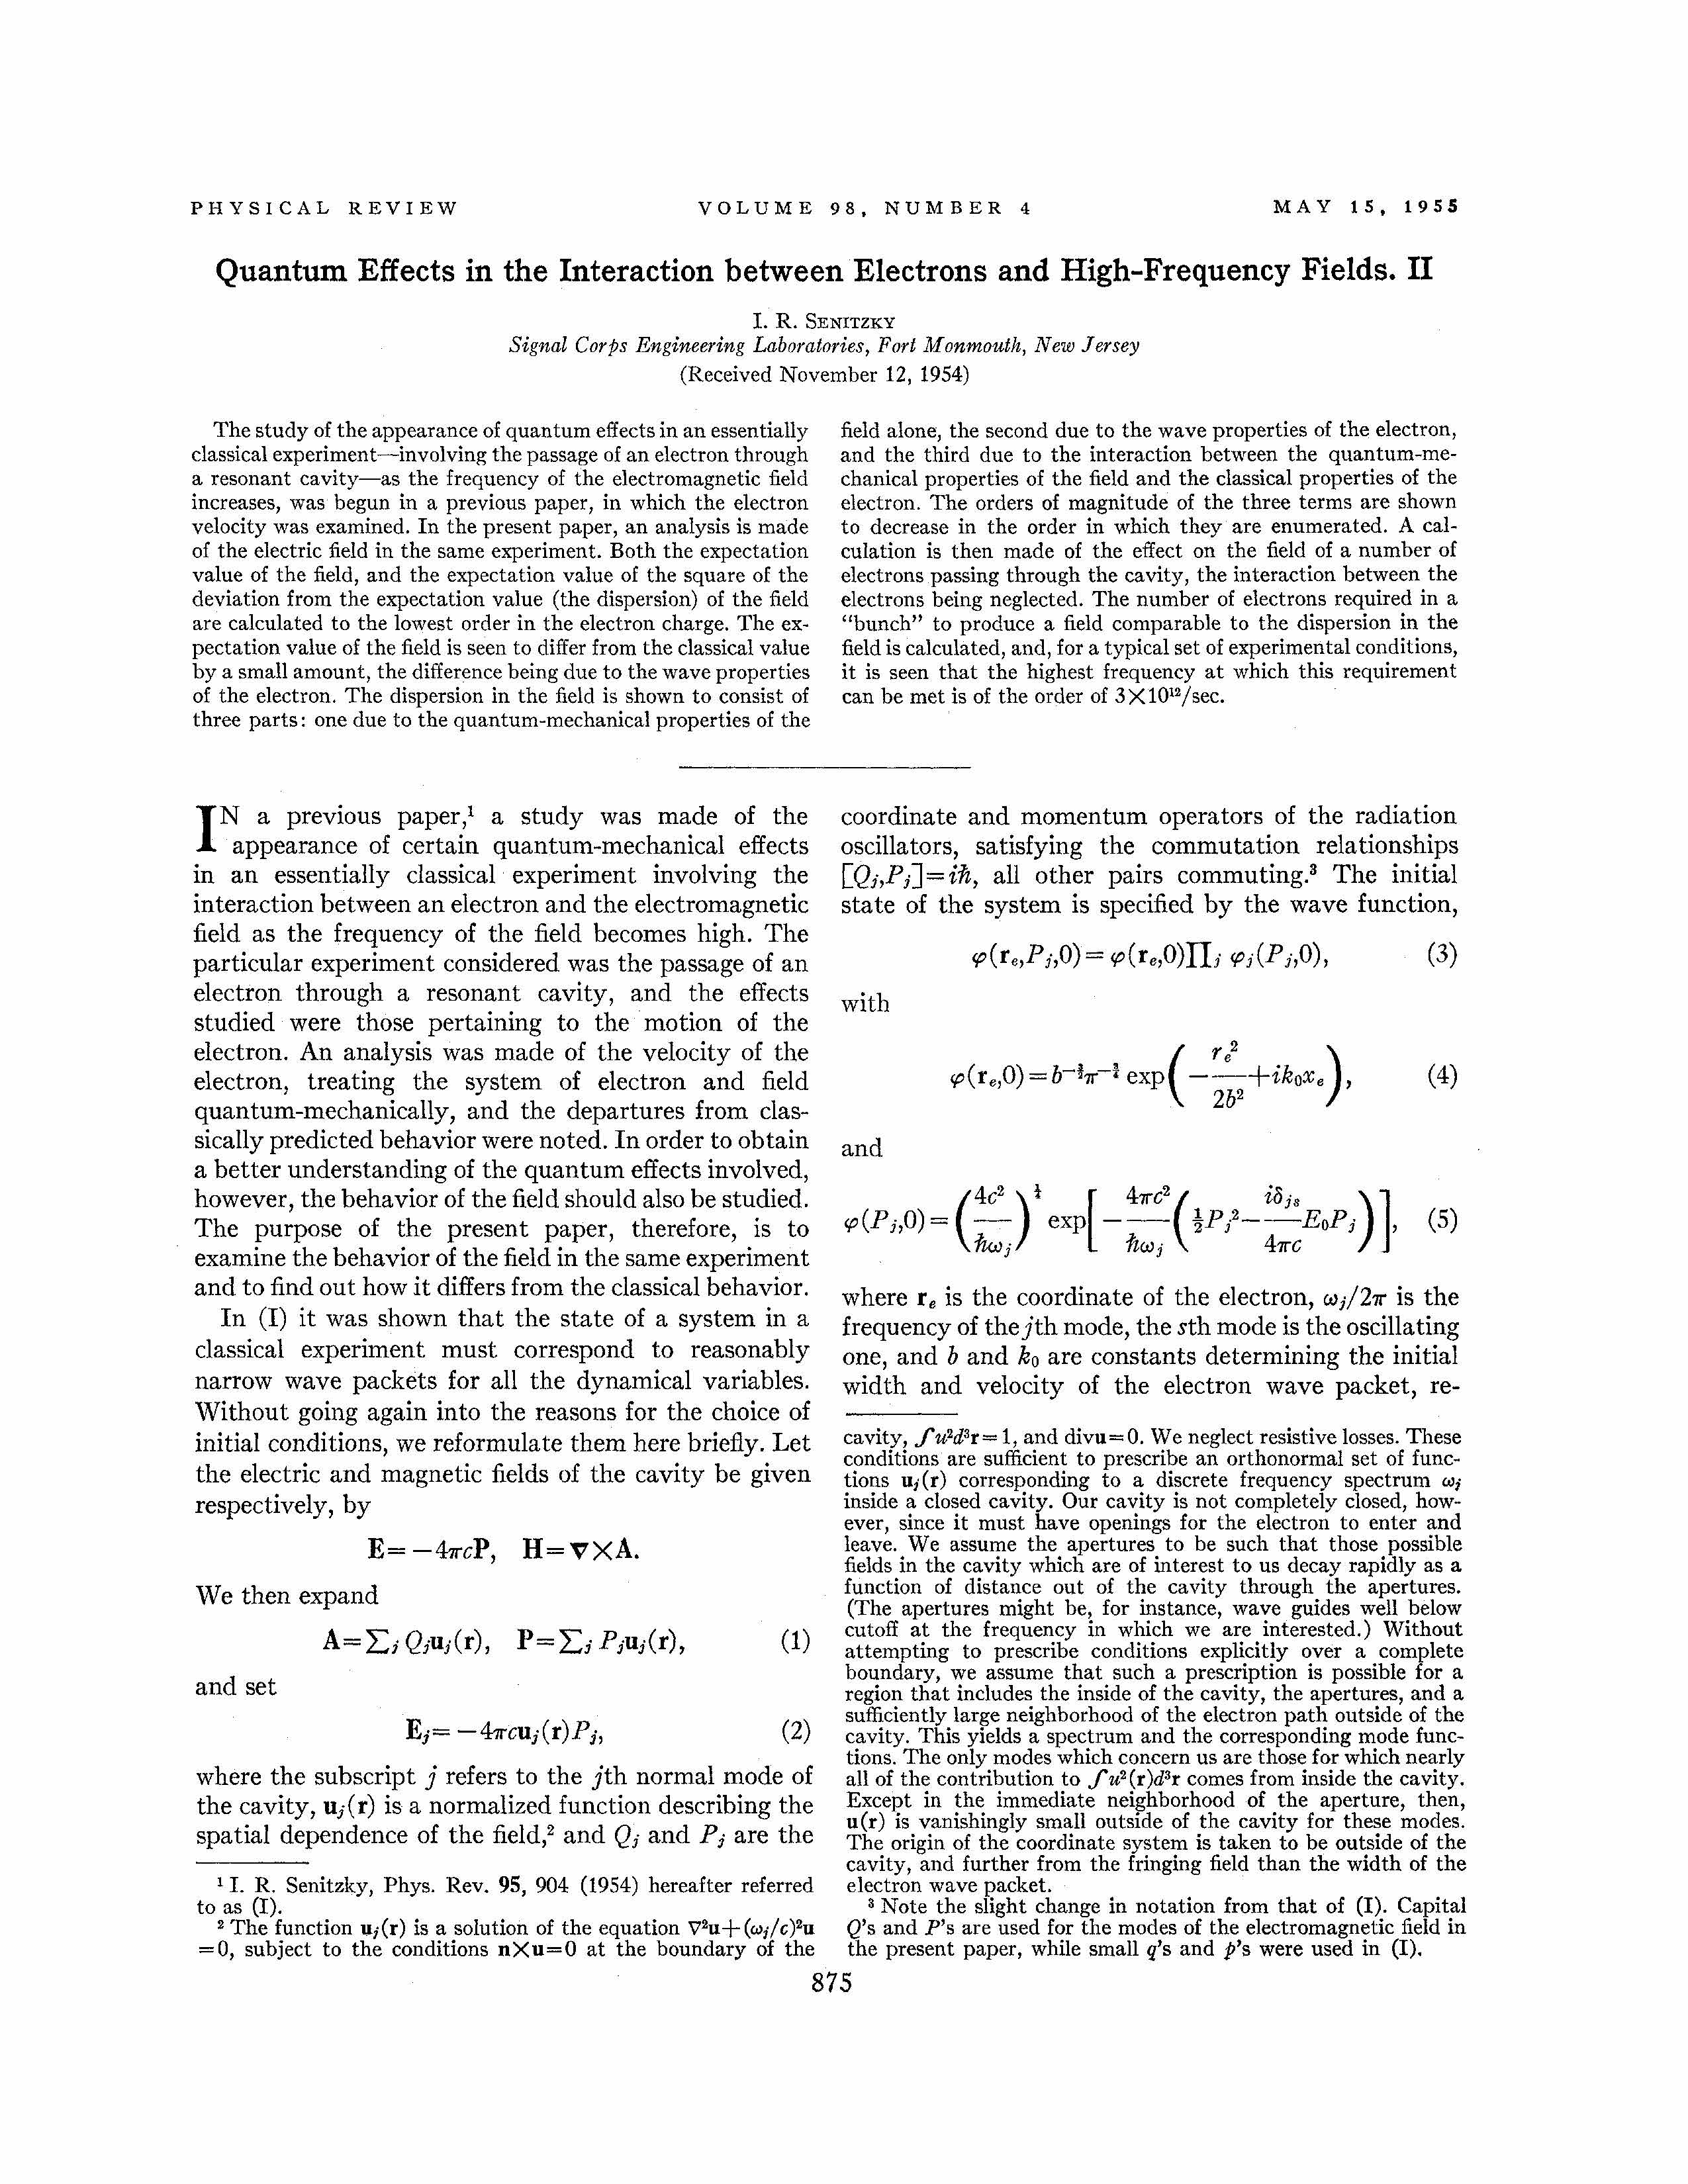

In [36]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [37]:
apsD2V.most_similar([apsD2V.docvecs['10.1103/PhysRev.98.875']], topn=5) 

[('volts', 0.8236003518104553),
 ('attaining', 0.8067859411239624),
 ('shielding', 0.7597390413284302),
 ('kv', 0.7478094100952148),
 ('vary', 0.7477940917015076)]

We can even look for documents most like a query composed of multiple words:

In [38]:
apsD2V.docvecs.most_similar([apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7578761577606201),
 ('10.1103/PhysRev.89.631', 0.7375411987304688),
 ('10.1103/PhysRev.108.570', 0.7350585460662842),
 ('10.1103/PhysRev.116.1583', 0.7231032848358154),
 ('10.1103/PhysRev.92.1218', 0.7129611968994141)]

Now let's plot some words and documents against one another with a heatmap:

In [39]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

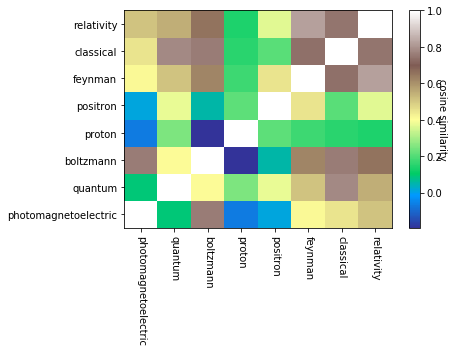

In [40]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [41]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

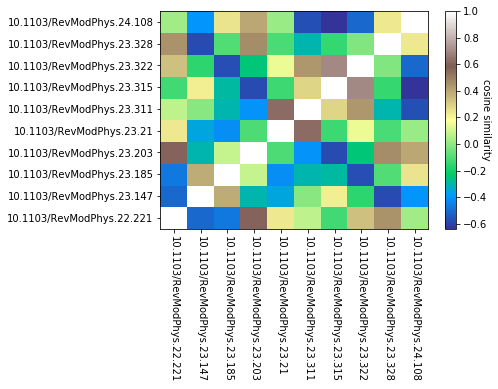

In [42]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [43]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

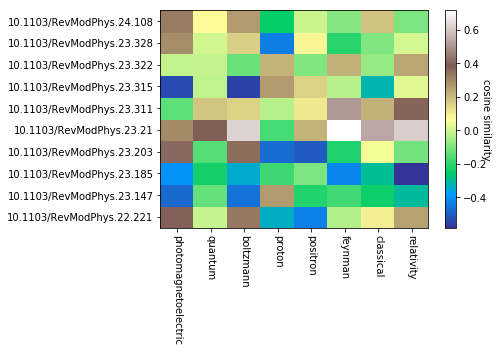

In [44]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [45]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [221]:
speechesW2V.wv.index2word[:5]

['people', 'year', 'america', 'world', 'nation']

In [222]:
ordersW2V.wv.index2word[:5]

['order', 'shall', 'state', 'agency', 'section']

In [223]:
dataW2V.wv.index2word[:5]

['order', 'state', 'shall', 'unite', 'agency']

In [224]:
data.head(2)

,title,president,date,text,subtype,tokenized_sents,normalized_sents
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech,"[[Chief, Justice, Roberts, Vice, President, Ha...","[[chief, justice, roberts, vice, president, ha..."
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech,"[[My, fellow, Americans, Four, years, ago, we,...","[[fellow, americans, year, ago, launch, great,..."


In [225]:
keywords = ['people', 'nation', 'health', 'peace', 'climate', 'president', 'executive', 'law', 'secretary', 'security']

In [226]:
data['tokenized_words'] = data['text'].apply(lambda x: lucem_illud.word_tokenize(x))
data['normalized_words'] = data['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [227]:
taggedDocs = []
for index, row in data.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['title'])
    docKeywords.append(row['president'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
data['TaggedAbstracts'] = taggedDocs

In [228]:
dataD2V = gensim.models.doc2vec.Doc2Vec(data['TaggedAbstracts'], size = 100)
speechesD2V = gensim.models.doc2vec.Doc2Vec(data[data['subtype'] == 'Speech']['TaggedAbstracts'], size = 100)
ordersD2V = gensim.models.doc2vec.Doc2Vec(data[data['subtype'] == 'Executive Order']['TaggedAbstracts'], size = 100)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [229]:
for word in ('race', 'climate', 'health'):
    print('Most similar words to ', word)
    print('In Speeches, are: ')
    print(speechesD2V.most_similar(word)[:5])
    print('In Executive Orders, are: ')
    print(ordersD2V.most_similar(word)[:5])
    print('In Both, are')
    print(dataD2V.most_similar(word)[:5])
    print('\\')

Most similar words to  race
In Speeches, are: 
[('oppression', 0.9958572387695312), ('resentment', 0.9949018955230713), ('tyranny', 0.9925462603569031), ('challenged', 0.9923638105392456), ('diversity', 0.9920676946640015)]
In Executive Orders, are: 
[('sexist', 0.9719378352165222), ('sex', 0.9694231748580933), ('inherently', 0.9190983772277832), ('racist', 0.9155211448669434), ('traits', 0.9123983383178711)]
In Both, are
[('sex', 0.9311612844467163), ('oppress', 0.9249486923217773), ('orientation', 0.8731952905654907), ('victim', 0.8658682107925415), ('claims', 0.8535645604133606)]
\
Most similar words to  climate
In Speeches, are: 
[('ensure', 0.9958585500717163), ('rebuild', 0.9948292970657349), ('keeping', 0.9916649460792542), ('cycle', 0.9893336296081543), ('changing', 0.9882777333259583)]
In Executive Orders, are: 
[('change', 0.9469322562217712), ('resilience', 0.9281704425811768), ('reprocessing', 0.9208927154541016), ('gross', 0.9197523593902588), ('africa', 0.9148733019828796

In [231]:
for word in ('race', 'climate', 'health'):
    print('In Speeches')
    print(word, 'to Obama is like')
    print(speechesD2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(speechesD2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('In Executive Orders')
    print(word, 'to Obama is like')
    print(ordersD2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(ordersD2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('In Both')
    print(word, 'to Obama is like')
    print(dataD2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(dataD2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('\\')

In Speeches
race to Obama is like
[('fighters', 0.9937449097633362), ('aspirations', 0.9931460618972778), ('democracy', 0.9927330017089844), ('cause', 0.9926660656929016), ('revolution', 0.9920471906661987)]
to Trump
 
And, race to Trump is like
[('empire', 0.9937779903411865), ('deter', 0.9937161207199097), ('western', 0.9927147030830383), ('aggression', 0.991823673248291), ('democracies', 0.9918171763420105)]
to Obama
 
In Executive Orders
race to Obama is like
[('disability', 0.838066577911377), ('barack', 0.8062669634819031), ('hope', 0.7900296449661255), ('doping', 0.7742182016372681), ('beauty', 0.7741672992706299)]
to Trump
 
And, race to Trump is like
[('eps', 0.899823784828186), ('â€ƒ', 0.8995569944381714), ('wait', 0.8889064788818359), ('agents', 0.8835865259170532), ('ob#1.eps', 0.8781814575195312)]
to Obama
 
In Both
race to Obama is like
[('religion', 0.857148289680481), ('discrimination', 0.8249677419662476), ('founded', 0.8116477727890015), ('color', 0.8056081533432007),

I think the results from D2V might make a bit more sense than the results from W2V.

In [232]:
def plot_D2V_heatmap(model, x_tags, y_tags):
    heatmapMatrix = []
    for tagOuter in y_tags:
        column = []
        tagVec = model.docvecs[tagOuter].reshape(1, -1)
        for tagInner in x_tags:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, model.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    heatmapMatrix = np.array(heatmapMatrix)
    
    fig, ax = plt.subplots()
    hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
    cbar = plt.colorbar(hmap)

    cbar.set_label('cosine similarity', rotation=270)
    a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
    a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

    a = ax.set_xticklabels(x_tags, minor=False, rotation=270)
    a = ax.set_yticklabels(y_tags, minor=False)
    
    plt.show()

Speeches


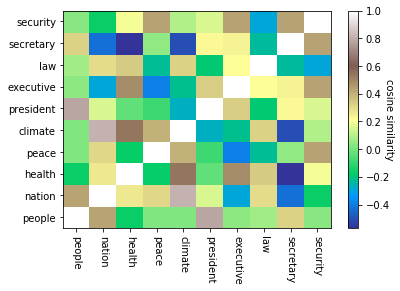

orders


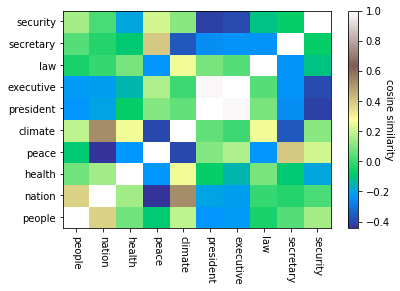

Both


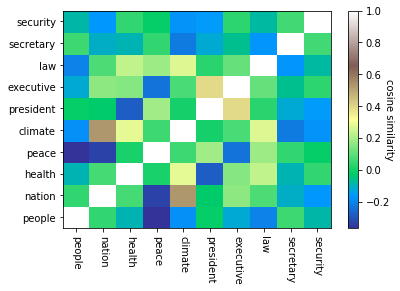

In [233]:
for model in ((speechesD2V, 'Speeches'), (ordersD2V, 'orders'), (dataD2V, 'Both')):
    print(model[1])
    plot_D2V_heatmap(model[0], keywords, keywords)

It looks like, the similarity between our keywords within Speeches are stronger and the similarity between our keywords within Executive Orders are weaker. This suggests that Speeches are more similar and use quite similar words whereas Executive Orders are more differentiated among each other. 

Another intersting observation is, in Speeches, 'climate' is highly similar to 'health' wheareas this degree of similarity is diminished in executive orders and 'climate' is more similar to 'nation'.

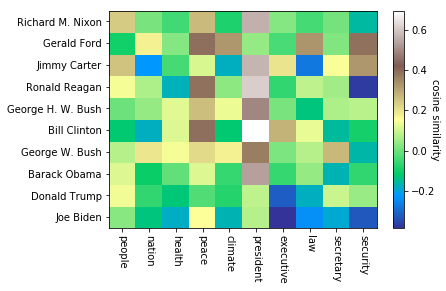

In [234]:
plot_D2V_heatmap(dataD2V, keywords, data['president'].unique()[:10])

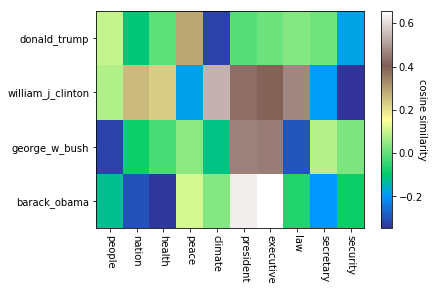

In [235]:
plot_D2V_heatmap(ordersD2V, keywords, data[data['subtype'] == 'Executive Order']['president'].unique()[:10])

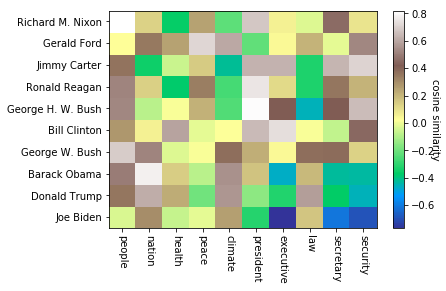

In [236]:
plot_D2V_heatmap(speechesD2V, keywords, data[data['subtype'] == 'Speech']['president'].unique()[:10])

There are actually quite intersting results associated with different presidents.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [47]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [48]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [49]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

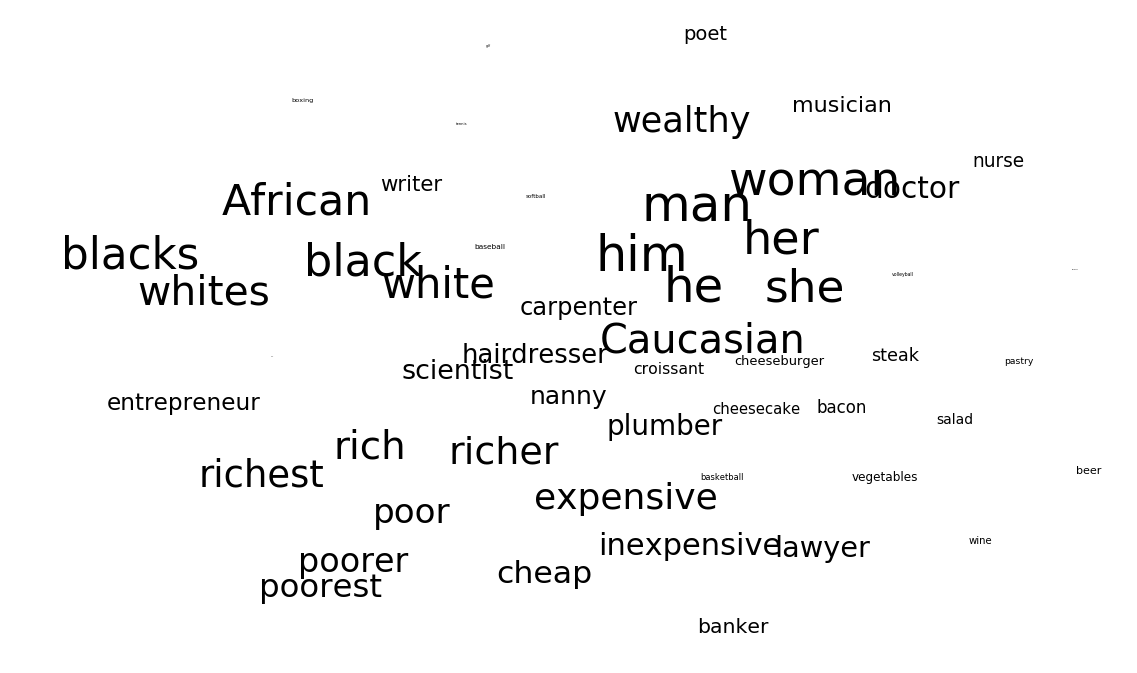

In [50]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [237]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [52]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [53]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [54]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [55]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [324]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

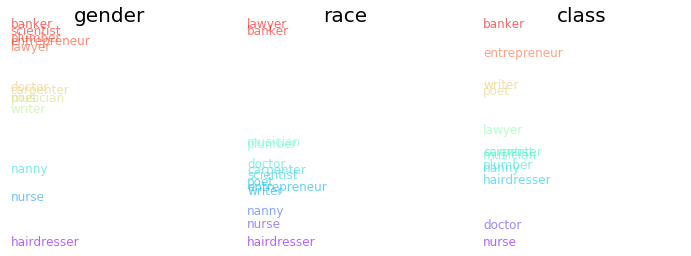

In [57]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

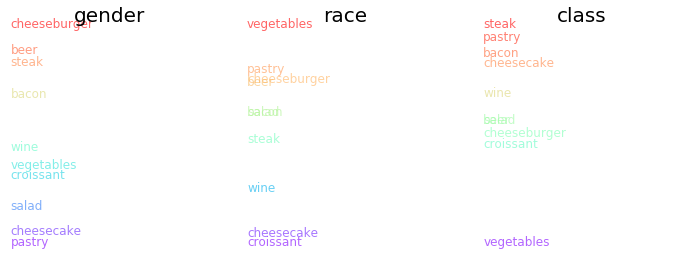

In [58]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

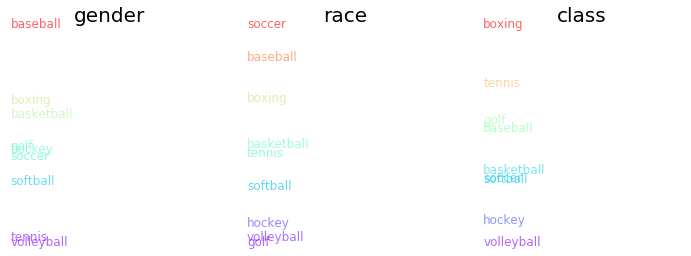

In [59]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [265]:
def plot_2D_with_targets(W2Vmodel, targetWords, n_components=2, plotType='tsne', size=True):
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(W2Vmodel[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    wordsSubMatrix

    if plotType == 'tsne':
        #pcaWords = sklearn.decomposition.PCA(n_components = n_components).fit(wordsSubMatrix)
        #reducedPCA_data = pcaWords.transform(wordsSubMatrix)
        plotWords = sklearn.manifold.TSNE(n_components = n_components).fit_transform(wordsSubMatrix)
    
    if plotType == 'pca':
        pcaWords = sklearn.decomposition.PCA(n_components = n_components).fit(wordsSubMatrix)
        plotWords = pcaWords.transform(wordsSubMatrix)
        #plotWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)   
        
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(plotWords[:, 0], plotWords[:, 1], alpha = 0)#Making the points invisible 
    if size:
        for i, word in enumerate(targetWords):
            ax.annotate(word, (plotWords[:, 0][i], plotWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    else:
        for i, word in enumerate(targetWords):
            ax.annotate(word, (plotWords[:, 0][i], plotWords[:, 1][i]))        
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [300]:
keywords = ['people', 'nation', 'peace', 'climate', 'president', 'executive', 'secretary', 'security']

In [301]:
keywords = keywords + ['health', 'fit', 'well', 'sick', 'disease', 'ill']
keywords = keywords + ['strict', 'regulate', 'law', 'deregulate', 'free']
keywords = keywords + ['warm', 'green', 'clean', 'energy', 'coal', 'job', 'economic']

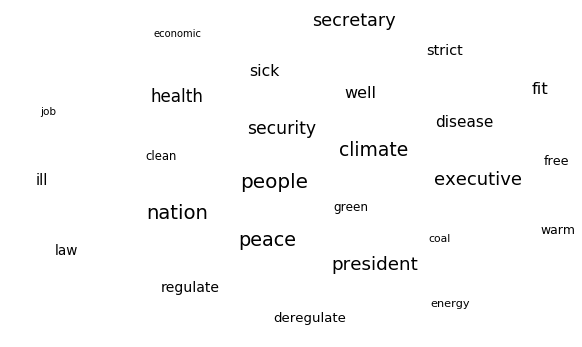

In [302]:
plot_2D_with_targets(dataW2V, keywords, n_components=2, plotType='tsne', size=True)

In [303]:
Health = dimension(dataW2V, ['health', 'fit', 'well'], ['sick', 'disease', 'ill'])
Regulate = dimension(dataW2V, ['strict', 'regulate', 'law'], ['deregulate', 'free'])
Climate = dimension(dataW2V, ['warm', 'green', 'clean'], ['energy', 'coal', 'job', 'economic'])

In [305]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Health.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Regulate.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Climate.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'Health': g, 'Regulate': r, 'Climate': c}, index = word_list)
    return df

In [320]:
Presidents = ['biden', 'trump', 'obama', 'bush', 'clinton', 'reagan','carter', 'ford','nixon', 'johnson']

In [322]:
Presidentsdf = makeDF(dataW2V, Presidents) 

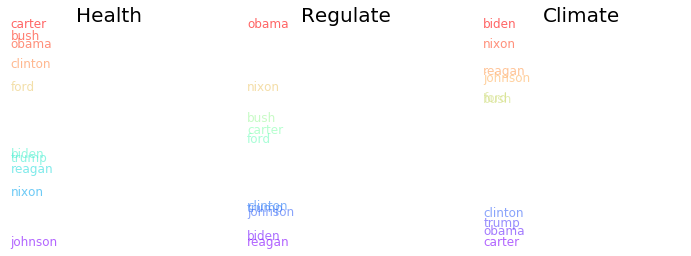

In [325]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Presidentsdf, 'Health')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Presidentsdf, 'Regulate')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Presidentsdf, 'Climate')
plt.show()

It's interesting. It looks like, Obama, Carter, Bush lean more towards health/wellness compared to Nixon, Johnson, which makes sense. Obama is more on the 'regulated' side wheareas Reagan is more on the 'free market' side, which also makes a lot of sense (it might be too early to tell for Biden). And lastly, Biden leans a lot towards 'climate' compared to Trump (makes sense), Obama and Carter (kinda weird, but it probably got to do with my dimension keywords). 

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [60]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [61]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [62]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [63]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [64]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [65]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [66]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [67]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [68]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [69]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [70]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [76]:
import copy

In [71]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [72]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [73]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [94]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, establish, main, drug, ..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, woman, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, establish, activity, high, response, ra..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[begin, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
5,1995,Breast Cancer,Validation of a model that identifies high ris...,GM Clark,Breast cancer patients with 10 or more positiv...,69,"[[Breast, cancer, patients, with, 10, or, more...","[[breast, cancer, patient, positive, lymph, no..."
6,1995,Genitourinary Cancer,Validation of the PROSQOLI: a pragmatic outcom...,M Stockler,Rationale: Traditional outcome measures are un...,649,"[[Rationale], [Traditional, outcome, measures,...","[[rationale], [traditional, outcome, measure, ..."
7,1995,Preclinical Experimental Therapeutics - Other,'In vitro' comparative assay on fluorouracil (...,A Abad,The clinical experience with biochemical modul...,1609,"[[The, clinical, experience, with, biochemical...","[[clinical, experience, biochemical, modulatio..."
8,1995,Tumor Biology,'Medical cultural diversity' among medical onc...,R Hochman,Most MO rely on prospective randomized trials....,1633,"[[Most, MO, rely, on, prospective, randomized,...","[[mo, rely, prospective, randomize, trial], [o..."
9,1995,Developmental TherapeuticsÑClinical Pharmacolo...,13-cis-retinoic acid plus low dose recombinant...,GM Turola,Both interferons and retinoids are known to po...,709,"[[Both, interferons, and, retinoids, are, know...","[[interferon, retinoid, know, possess, antipro..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [183]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [184]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [77]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [95]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [78]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


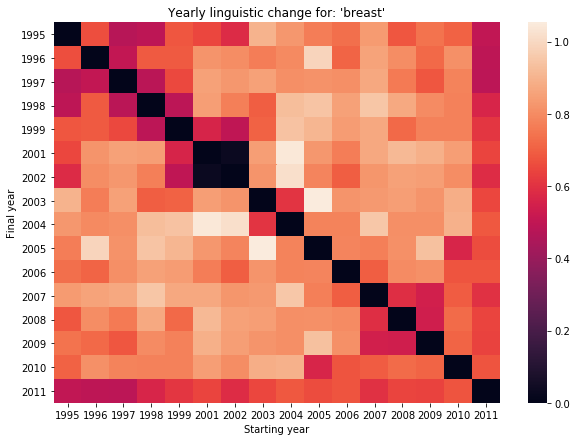

In [79]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


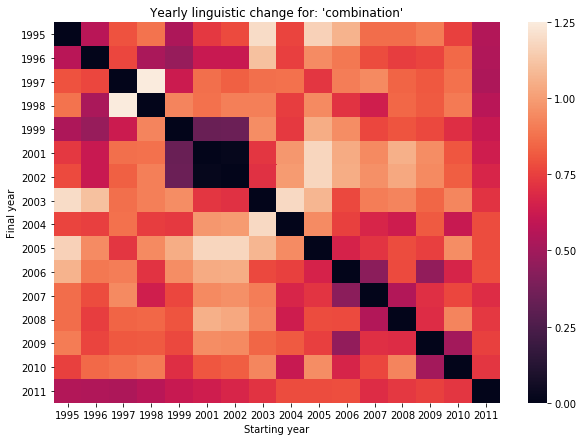

In [80]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [81]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [82]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [83]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [84]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


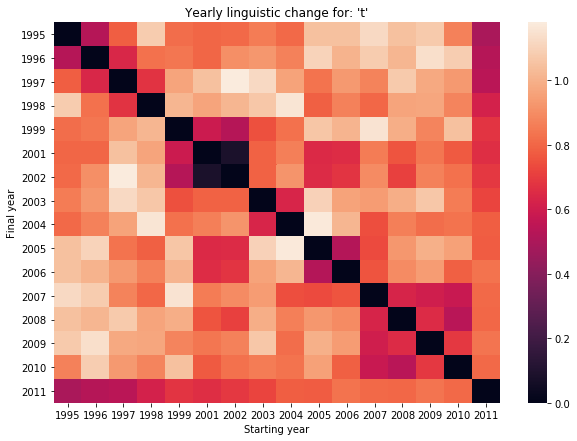

In [85]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


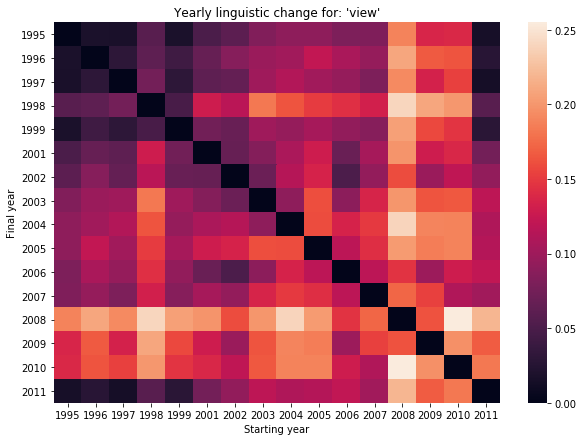

In [86]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [88]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [89]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [114]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [115]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud_2020.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [176]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [178]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [179]:
from gensim.models import Word2Vec

In [191]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [192]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [193]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [194]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 2, 3, 4])

In [195]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). 
You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 